In [1]:
import numpy as np
from numpy.random import default_rng

import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from jax import random

import optax 
import make_dataset as mkds
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
from tqdm.auto import tqdm

# Standard libraries
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

import make_dataset as mkds
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger


2023-03-14 12:15:30.020337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-03-14 12:15:30.020417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_

In [2]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data


class PerturbMNIST(Dataset):
    """
    Simple dataset class that stores the data and targets as NumPy arrays.
    
    Args:
    -----
        data: np.ndarray
            The perturbed input data.
        targets: np.ndarray
            The empirical field that generated the perturbed data.
    """
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.targets)
    
    def __getitem__(self, idx: int):
        """
        Returns the i-th sample and corresponding target in the dataset.
        
        Args:
        -----
            idx: int
                The index of the sample to return.
                
        Returns:
        --------
            tuple: A tuple containing the sample and target.
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
    
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

def create_data_loaders(*datasets : Sequence[data.Dataset],
                        train : Union[bool, Sequence[bool]] = True,
                        batch_size : int = 128,
                        num_workers : int = 4,
                        seed : int = 42):
    """
    Creates data loaders used in JAX for a set of datasets.

    Args:
      datasets: Datasets for which data loaders are created.
      train: Sequence indicating which datasets are used for
        training and which not. If single bool, the same value
        is used for all datasets.
      batch_size: Batch size to use in the data loaders.
      num_workers: Number of workers for each dataset.
      seed: Seed to initialize the workers and shuffling with.
    """
    loaders = []
    if not isinstance(train, (list, tuple)):
        train = [train for _ in datasets]
    for dataset, is_train in zip(datasets, train):
        loader = data.DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=is_train,
                                 drop_last=is_train,
                                 collate_fn=numpy_collate,
                                 num_workers=num_workers,
                                 persistent_workers=is_train,
                                 generator=torch.Generator().manual_seed(seed))
        loaders.append(loader)
    return loaders

In [3]:
perturbed_training = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_training_set.pkl')

perturbed_val = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_val_set.pkl')

perturbed_test = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_test_set.pkl')



training = PerturbMNIST(perturbed_training[0], perturbed_training[1])
val = PerturbMNIST(perturbed_val[0], perturbed_val[1])
testing = PerturbMNIST(perturbed_test[0], perturbed_test[1])

train_dl, val_dl, test_dl = create_data_loaders(training, val, testing,
                                                train=[True, False, False],
                                                batch_size=128)

# train_dl = DataLoader(training, 
#                       collate_fn=mkds.numpy_collate,
#                       batch_size=128) # create your dataloader

# val_dl = DataLoader(val,
#                     collate_fn=mkds.numpy_collate,
#                     batch_size=128) # create your dataloader

# test_dl = DataLoader(testing, 
#                      collate_fn=mkds.numpy_collate,
#                      batch_size=128) # create your dataloader

In [4]:
CHECKPOINT_PATH = '/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_models'

# 1. Load the data

# 2. Make training pipeline

In [5]:
from flax.training import train_state, checkpoints
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)

In [6]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    # If a model has no batch statistics, it is None
    batch_stats : Any = None
    # You can further extend the TrainState by any additional part here
    # For example, rng to keep for init, dropout, etc.
    rng : Any = None

In [7]:
class TrainerModule:

    def __init__(self,
                 model_class : nn.Module,
                 model_hparams : Dict[str, Any],
                 optimizer_hparams : Dict[str, Any],
                 exmp_input : Any,
                 seed : int = 42,
                 logger_params : Dict[str, Any] = None,
                 enable_progress_bar : bool = True,
                 debug : bool = False,
                 check_val_every_n_epoch : int = 1,
                 **kwargs):
        """
        A basic Trainer module summarizing most common training functionalities
        like logging, model initialization, training loop, etc.

        Atributes:
          model_class: The class of the model that should be trained.
          model_hparams: A dictionary of all hyperparameters of the model. Is
            used as input to the model when created.
          optimizer_hparams: A dictionary of all hyperparameters of the optimizer.
            Used during initialization of the optimizer.
          exmp_input: Input to the model for initialization and tabulate.
          seed: Seed to initialize PRNG.
          logger_params: A dictionary containing the specification of the logger.
          enable_progress_bar: If False, no progress bar is shown.
          debug: If True, no jitting is applied. Can be helpful for debugging.
          check_val_every_n_epoch: The frequency with which the model is evaluated
            on the validation set.
        """
        super().__init__()
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_hparams = optimizer_hparams
        self.enable_progress_bar = enable_progress_bar
        self.debug = debug
        self.seed = seed
        self.check_val_every_n_epoch = check_val_every_n_epoch
        self.exmp_input = exmp_input
        # Set of hyperparameters to save
        self.config = {
            'model_class': model_class.__name__,
            'model_hparams': model_hparams,
            'optimizer_hparams': optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_n_epoch': check_val_every_n_epoch,
            'seed': self.seed
        }
        self.config.update(kwargs)
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        self.print_tabulate(exmp_input)
        # Init trainer parts
        self.init_logger(logger_params)
        self.create_jitted_functions()
        self.init_model(exmp_input)

    def init_logger(self,
                    logger_params : Optional[Dict] = None):
        """
        Initializes a logger and creates a logging directory.

        Args:
          logger_params: A dictionary containing the specification of the logger.
        """
        if logger_params is None:
            logger_params = dict()
        # Determine logging directory
        log_dir = logger_params.get('log_dir', None)
        if not log_dir:
            base_log_dir = logger_params.get('base_log_dir', 'checkpoints/')
            # Prepare logging
            log_dir = os.path.join(base_log_dir, self.config["model_class"])
            if 'logger_name' in logger_params:
                log_dir = os.path.join(log_dir, logger_params['logger_name'])
            version = None
        else:
            version = ''
        # Create logger object
        logger_type = logger_params.get('logger_type', 'TensorBoard').lower()
        if logger_type == 'tensorboard':
            self.logger = TensorBoardLogger(save_dir=log_dir,
                                            version=version,
                                            name='')
        elif logger_type == 'wandb':
            self.logger = WandbLogger(name=logger_params.get('project_name', None),
                                      save_dir=log_dir,
                                      version=version,
                                      config=self.config)
        else:
            assert False, f'Unknown logger type \"{logger_type}\"'
        # Save hyperparameters
        log_dir = self.logger.log_dir
        if not os.path.isfile(os.path.join(log_dir, 'hparams.json')):
            os.makedirs(os.path.join(log_dir, 'metrics/'), exist_ok=True)
            with open(os.path.join(log_dir, 'hparams.json'), 'w') as f:
                json.dump(self.config, f, indent=4)
        self.log_dir = log_dir

    def init_model(self,
                   exmp_input : Any):
        """
        Creates an initial training state with newly generated network parameters.

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
        """
        # Prepare PRNG and input
        model_rng = random.PRNGKey(self.seed)
        model_rng, init_rng = random.split(model_rng)
        exmp_input = [exmp_input] if not isinstance(exmp_input, (list, tuple)) else exmp_input
        # Run model initialization
        variables = self.run_model_init(exmp_input, init_rng)
        # Create default state. Optimizer is initialized later
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=variables['params'],
                                batch_stats=variables.get('batch_stats'),
                                rng=model_rng,
                                tx=None,
                                opt_state=None)

    def run_model_init(self,
                       exmp_input : Any,
                       init_rng : Any) -> Dict:
        """
        The model initialization call

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
          init_rng: A jax.random.PRNGKey.

        Returns:
          The initialized variable dictionary.
        """
        return self.model.init(init_rng, *exmp_input, train=True)

    def print_tabulate(self,
                       exmp_input : Any):
        """
        Prints a summary of the Module represented as table.

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
        """
        print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))

    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Args:
          num_epochs: Number of epochs the model will be trained for.
          num_steps_per_epoch: Number of training steps per epoch.
        """
        hparams = copy(self.optimizer_hparams)

        # Initialize optimizer
        optimizer_name = hparams.pop('optimizer', 'adamw')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # Initialize learning rate scheduler
        # A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 1.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       batch_stats=self.state.batch_stats,
                                       tx=optimizer,
                                       rng=self.state.rng)

    def create_jitted_functions(self):
        """
        Creates jitted versions of the training and evaluation functions.
        If self.debug is True, not jitting is applied.
        """
        train_step, eval_step = self.create_functions()
        if self.debug:  # Skip jitting
            print('Skipping jitting due to debug=True')
            self.train_step = train_step
            self.eval_step = eval_step
        else:
            self.train_step = jax.jit(train_step)
            self.eval_step = jax.jit(eval_step)

    def create_functions(self) -> Tuple[Callable[[TrainState, Any], Tuple[TrainState, Dict]],
                                        Callable[[TrainState, Any], Tuple[TrainState, Dict]]]:
        """
        Creates and returns functions for the training and evaluation step. The
        functions take as input the training state and a batch from the train/
        val/test loader. Both functions are expected to return a dictionary of
        logging metrics, and the training function a new train state. This
        function needs to be overwritten by a subclass. The train_step and
        eval_step functions here are examples for the signature of the functions.
        """
        def train_step(state : TrainState,
                       batch : Any):
            metrics = {}
            return state, metrics
        def eval_step(state : TrainState,
                      batch : Any):
            metrics = {}
            return metrics
        raise NotImplementedError

    def train_model(self,
                    train_loader : Iterator,
                    val_loader : Iterator,
                    test_loader : Optional[Iterator] = None,
                    num_epochs : int = 500) -> Dict[str, Any]:
        """
        Starts a training loop for the given number of epochs.

        Args:
          train_loader: Data loader of the training set.
          val_loader: Data loader of the validation set.
          test_loader: If given, best model will be evaluated on the test set.
          num_epochs: Number of epochs for which to train the model.

        Returns:
          A dictionary of the train, validation and evt. test metrics for the
          best model on the validation set.
        """
        # Create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Prepare training loop
        self.on_training_start()
        best_eval_metrics = None
        for epoch_idx in self.tracker(range(1, num_epochs+1), desc='Epochs'):
            train_metrics = self.train_epoch(train_loader)
            self.logger.log_metrics(train_metrics, step=epoch_idx)
            self.on_training_epoch_end(epoch_idx)
            # Validation every N epochs
            if epoch_idx % self.check_val_every_n_epoch == 0:
                eval_metrics = self.eval_model(val_loader, log_prefix='val/')
                self.on_validation_epoch_end(epoch_idx, eval_metrics, val_loader)
                self.logger.log_metrics(eval_metrics, step=epoch_idx)
                self.save_metrics(f'eval_epoch_{str(epoch_idx).zfill(3)}', eval_metrics)
                # Save best model
                if self.is_new_model_better(eval_metrics, best_eval_metrics):
                    best_eval_metrics = eval_metrics
                    best_eval_metrics.update(train_metrics)
                    self.save_model(step=epoch_idx)
                    self.save_metrics('best_eval', eval_metrics)
        # Test best model if possible
        if test_loader is not None:
            self.load_model()
            test_metrics = self.eval_model(test_loader, log_prefix='test/')
            self.logger.log_metrics(test_metrics, step=epoch_idx)
            self.save_metrics('test', test_metrics)
            best_eval_metrics.update(test_metrics)
        # Close logger
        self.logger.finalize('success')
        return best_eval_metrics

    def train_epoch(self,
                    train_loader : Iterator) -> Dict[str, Any]:
        """
        Trains a model for one epoch.

        Args:
          train_loader: Data loader of the training set.

        Returns:
          A dictionary of the average training metrics over all batches
          for logging.
        """
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(float)
        num_train_steps = len(train_loader)
        start_time = time.time()
        for batch in self.tracker(train_loader, desc='Training', leave=False):
            self.state, step_metrics = self.train_step(self.state, batch)
            for key in step_metrics:
                metrics['train/' + key] += step_metrics[key] / num_train_steps
        metrics = {key: metrics[key].item() for key in metrics}
        metrics['epoch_time'] = time.time() - start_time
        return metrics

    def eval_model(self,
                   data_loader : Iterator,
                   log_prefix : Optional[str] = '') -> Dict[str, Any]:
        """
        Evaluates the model on a dataset.

        Args:
          data_loader: Data loader of the dataset to evaluate on.
          log_prefix: Prefix to add to all metrics (e.g. 'val/' or 'test/')

        Returns:
          A dictionary of the evaluation metrics, averaged over data points
          in the dataset.
        """
        # Test model on all images of a data loader and return avg loss
        metrics = defaultdict(float)
        num_elements = 0
        for batch in data_loader:
            step_metrics = self.eval_step(self.state, batch)
            batch_size = batch[0].shape[0] if isinstance(batch, (list, tuple)) else batch.shape[0]
            for key in step_metrics:
                metrics[key] += step_metrics[key] * batch_size
            num_elements += batch_size
        metrics = {(log_prefix + key): (metrics[key] / num_elements).item() for key in metrics}
        return metrics

    def is_new_model_better(self,
                            new_metrics : Dict[str, Any],
                            old_metrics : Dict[str, Any]) -> bool:
        """
        Compares two sets of evaluation metrics to decide whether the
        new model is better than the previous ones or not.

        Args:
          new_metrics: A dictionary of the evaluation metrics of the new model.
          old_metrics: A dictionary of the evaluation metrics of the previously
            best model, i.e. the one to compare to.

        Returns:
          True if the new model is better than the old one, and False otherwise.
        """
        if old_metrics is None:
            return True
        for key, is_larger in [('val/val_metric', False), ('val/acc', True), ('val/loss', False)]:
            if key in new_metrics:
                if is_larger:
                    return new_metrics[key] > old_metrics[key]
                else:
                    return new_metrics[key] < old_metrics[key]
        assert False, f'No known metrics to log on: {new_metrics}'

    def tracker(self,
                iterator : Iterator,
                **kwargs) -> Iterator:
        """
        Wraps an iterator in a progress bar tracker (tqdm) if the progress bar
        is enabled.

        Args:
          iterator: Iterator to wrap in tqdm.
          kwargs: Additional arguments to tqdm.

        Returns:
          Wrapped iterator if progress bar is enabled, otherwise same iterator
          as input.
        """
        if self.enable_progress_bar:
            return tqdm(iterator, **kwargs)
        else:
            return iterator

    def save_metrics(self,
                     filename : str,
                     metrics : Dict[str, Any]):
        """
        Saves a dictionary of metrics to file. Can be used as a textual
        representation of the validation performance for checking in the terminal.

        Args:
          filename: Name of the metrics file without folders and postfix.
          metrics: A dictionary of metrics to save in the file.
        """
        with open(os.path.join(self.log_dir, f'metrics/{filename}.json'), 'w') as f:
            json.dump(metrics, f, indent=4)

    def on_training_start(self):
        """
        Method called before training is started. Can be used for additional
        initialization operations etc.
        """
        pass

    def on_training_epoch_end(self,
                              epoch_idx : int):
        """
        Method called at the end of each training epoch. Can be used for additional
        logging or similar.

        Args:
          epoch_idx: Index of the training epoch that has finished.
        """
        pass

    def on_validation_epoch_end(self,
                                epoch_idx : int,
                                eval_metrics : Dict[str, Any],
                                val_loader : Iterator):
        """
        Method called at the end of each validation epoch. Can be used for additional
        logging and evaluation.

        Args:
          epoch_idx: Index of the training epoch at which validation was performed.
          eval_metrics: A dictionary of the validation metrics. New metrics added to
            this dictionary will be logged as well.
          val_loader: Data loader of the validation set, to support additional
            evaluation.
        """
        pass

    def save_model(self,
                   step : int = 0):
        """
        Saves current training state at certain training iteration. Only the model
        parameters and batch statistics are saved to reduce memory footprint. To
        support the training to be continued from a checkpoint, this method can be
        extended to include the optimizer state as well.

        Args:
          step: Index of the step to save the model at, e.g. epoch.
        """
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params,
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                    overwrite=True)

    def load_model(self):
        """
        Loads model parameters and batch statistics from the logging directory.
        """
        state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       # Optimizer will be overwritten when training starts
                                       tx=self.state.tx if self.state.tx else optax.sgd(0.1),
                                       rng=self.state.rng
                                      )

    def bind_model(self):
        """
        Returns a model with parameters bound to it. Enables an easier inference
        access.

        Returns:
          The model with parameters and evt. batch statistics bound to it.
        """
        params = {'params': self.state.params}
        if self.state.batch_stats:
            params['batch_stats'] = self.state.batch_stats
        return self.model.bind(params)

    @classmethod
    def load_from_checkpoint(cls,
                             checkpoint : str,
                             exmp_input : Any) -> Any:
        """
        Creates a Trainer object with same hyperparameters and loaded model from
        a checkpoint directory.

        Args:
          checkpoint: Folder in which the checkpoint and hyperparameter file is stored.
          exmp_input: An input to the model for shape inference.

        Returns:
          A Trainer object with model loaded from the checkpoint folder.
        """
        hparams_file = os.path.join(checkpoint, 'hparams.json')
        assert os.path.isfile(hparams_file), 'Could not find hparams file'
        with open(hparams_file, 'r') as f:
            hparams = json.load(f)
        hparams.pop('model_class')
        hparams.update(hparams.pop('model_hparams'))
        if not hparams['logger_params']:
            hparams['logger_params'] = dict()
        hparams['logger_params']['log_dir'] = checkpoint
        trainer = cls(exmp_input=exmp_input,
                      **hparams)
        trainer.load_model()
        return trainer

## 1. Define Network

In [8]:
class MLPRegressor(nn.Module):
    hidden_dims : Sequence[int]
    output_dim : int

    @nn.compact
    def __call__(self, x, **kwargs):
        for dims in self.hidden_dims:
            x = nn.Dense(dims)(x)
            x = nn.silu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [9]:
# # View model layers
# mlp = MLPRegressor(hidden_dims=[1850],
#           output_dim=785)

# print(mlp.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 785))))

In [10]:
class MLPRegressTrainer(TrainerModule):

    def __init__(self,
                 hidden_dims : Sequence[int],
                 output_dim : int,
                 **kwargs):
        super().__init__(model_class=MLPRegressor,
                         model_hparams={
                             'hidden_dims': hidden_dims,
                             'output_dim': output_dim
                         },
                         **kwargs)

    def create_functions(self):
        def mse_loss(params, batch):
            x, y = batch
            pred = self.model.apply({'params': params}, x)
            loss = ((pred - y) ** 2).mean()
            return loss

        def train_step(state, batch):
            loss_fn = lambda params: mse_loss(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics

        def eval_step(state, batch):
            loss = mse_loss(state.params, batch)
            return {'loss': loss}

        return train_step, eval_step

Commented code trains the model

In [11]:
# trainer = MLPRegressTrainer(hidden_dims=[785, 785, 785],
#                             output_dim=785,
#                             optimizer_hparams={'lr': 4e-3,
#                                                'optimizer': 'adam'},
#                             logger_params={'base_log_dir': CHECKPOINT_PATH,
#                                            'logger_type': 'tensorboard'},
#                             exmp_input=next(iter(train_dl))[0:1],
#                             check_val_every_n_epoch=50)

# metrics = trainer.train_model(train_dl,
#                               val_dl,
#                               test_loader=test_dl,
#                               num_epochs=500)

# print(f'Training loss: {metrics["train/loss"]}')
# print(f'Validation loss: {metrics["val/loss"]}')
# print(f'Test loss: {metrics["test/loss"]}')

Code below reloads the trained model

In [12]:
# model_dir = '/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_models/MLPRegressor/version_9'
model_dir = '/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_models/MLPRegressor/version_12'

In [13]:
trainer_loader = MLPRegressTrainer.load_from_checkpoint(checkpoint=model_dir,
                                                        exmp_input=next(iter(train_dl))[0:1])


                              MLPRegressor Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module       ┃ inputs          ┃ outputs         ┃ params          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         │ MLPRegressor │ -               │ float32[128,78… │                 │
│         │              │ float32[128,78… │                 │                 │
│         │              │ - train: True   │                 │                 │
├─────────┼──────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Dense_0 │ Dense        │ float32[128,78… │ float32[128,78… │ bias:           │
│         │              │                 │                 │ float32[785]    │
│         │              │                 │                 │ kernel:         │
│         │              │                 │                 │ float32[785,78… │
│         │              │ 

In [14]:
train_ds, test_ds = mkds.download_MNIST()
test_data, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()
test_data = mkds.reshape_with_channel_dim(test_data)
perturbed_test_data = mkds.process_perturbed_data(test_data, jax.random.PRNGKey(7))

In [15]:
perturbed_test_data[0].shape

(10000, 785)

In [16]:
model_bd = trainer_loader.bind_model()
batch = next(iter(test_dl))
pred = model_bd(batch)

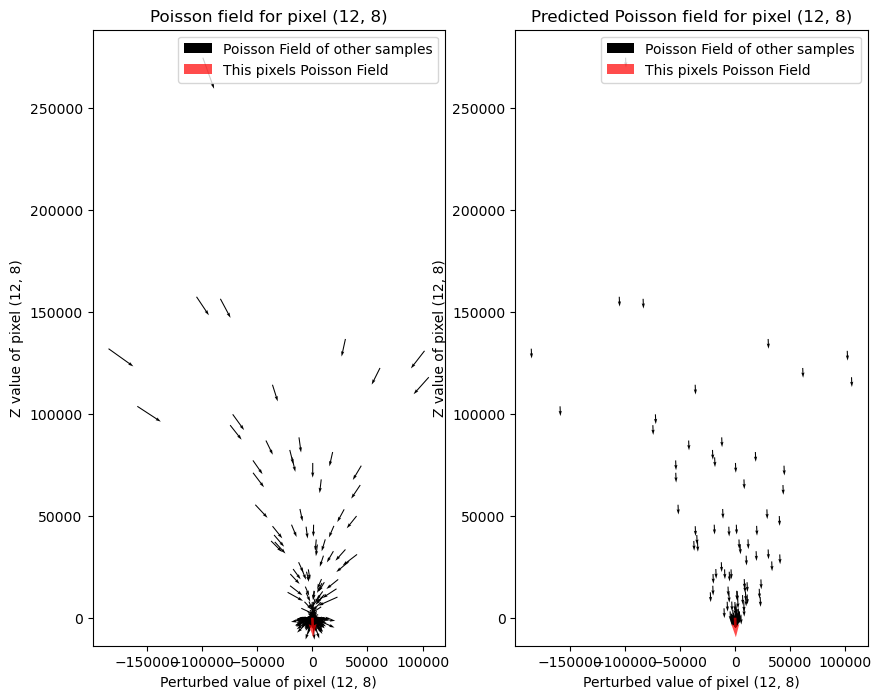

In [17]:
import matplotlib.pyplot as plt

batchsize=400
sample_idx=0
x_coord=12
y_coord=8
rng = jax.random.PRNGKey(21)
grid_lims=40
# figure_name: str
# figure_dir: str = 'figures/'

train_ds, test_ds = mkds.download_MNIST()
test_data, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()
test_data = mkds.reshape_with_channel_dim(test_data)
perturbed_test_data = mkds.process_perturbed_data(test_data, jax.random.PRNGKey(7))

vis_batch = perturbed_test_data[0][:batchsize]
truth = perturbed_test_data[1][:batchsize]


model_bd = trainer_loader.bind_model()
pred = model_bd(vis_batch)

flat_coord = x_coord * 28 + y_coord
everything_except = np.arange(len(vis_batch)) != sample_idx


fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].quiver(vis_batch[everything_except, flat_coord], vis_batch[everything_except,-1],
             truth[everything_except, flat_coord], truth[everything_except,-1], label='Poisson Field of other samples');
# This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
# this one pixel is mapped into the N+1 dimension above the hyperplane.
ax[0].quiver(vis_batch[sample_idx, flat_coord], vis_batch[sample_idx,-1],
             pred[sample_idx, flat_coord], pred[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
ax[0].set_title(f'Poisson field for pixel {x_coord, y_coord}')
ax[0].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
ax[0].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
ax[0].legend()
ax[1].quiver(vis_batch[everything_except, flat_coord], vis_batch[everything_except,-1],
             pred[everything_except, flat_coord], pred[everything_except,-1], label='Poisson Field of other samples');
# This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
# this one pixel is mapped into the N+1 dimension above the hyperplane.
ax[1].quiver(vis_batch[sample_idx, flat_coord], vis_batch[sample_idx,-1],
             pred[sample_idx, flat_coord], pred[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
ax[1].set_title(f'Predicted Poisson field for pixel {x_coord, y_coord}')
ax[1].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
ax[1].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
ax[1].legend()
plt.show()